# Forecasting using CNN

- One-step recursive forecasting

In [1]:
import pandas as pd
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing methods
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# accuracy measures and data spliting
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# deep learning libraries
from keras.models import Input, Model
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import callbacks
from keras import initializers
from keras import regularizers

import warnings

Using TensorFlow backend.


In [2]:
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 15, 7

## 1. Data import

In [4]:
DATADIR = '../data/power-consumption/'
MODELDIR = '../checkpoints/power/ffnn/model/'

data = pd.read_csv(os.path.join(DATADIR, 'processed_data.csv'))

data.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4,Month,Weekday,WeekOfYear,Median_active_power,Lagged_active_power,median_residual
0,2006-12-16,1209.176,34.922,236.243763,5180.8,0.0,546.0,4926.0,14680.933333,12,5,50,2437.799,2437.799,-1228.623
1,2006-12-17,3390.460,226.006,240.087028,14398.6,2033.0,4187.0,13341.0,36946.666667,12,6,50,2437.894,1209.176,952.566
2,2006-12-18,2203.826,161.792,241.231694,9247.2,1063.0,2621.0,14018.0,19028.433333,12,0,51,1833.155,3390.460,370.671
3,2006-12-19,1666.194,150.942,241.999313,7094.0,839.0,7602.0,6197.0,13131.900000,12,1,51,1971.630,2203.826,-305.436
4,2006-12-20,2225.748,160.998,242.308063,9313.0,0.0,2648.0,14063.0,20384.800000,12,2,51,2031.487,1666.194,194.261


## 2. Train test split

In [5]:
y = data[['Global_active_power']].copy()
X = data.drop(columns=['date', 'Global_active_power', 'Median_active_power', 'Lagged_active_power', 'median_residual'], axis=1)

# last 40 weeks data for testing
test_size = np.int16(7*1)
train_size = X.shape[0] - test_size

# scaling weekly sales, dependent variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values)

# scaling numerical column from features
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X.values)

X_train, X_test = X_scaled[:train_size-1, :], X_scaled[train_size:, :]
y_train, y_test = y_scaled[:train_size-1, :], y_scaled[train_size:, :]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1434, 10), (7, 10), (1434, 1), (7, 1))

## 4. Model Builing

In [6]:
timesteps = 1
features = X_train.shape[1]

X_train = np.reshape(X_train, (X_train.shape[0], timesteps, features))
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, features))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1434, 1, 10), (7, 1, 10), (1434, 1), (7, 1))

In [7]:
def model_construction():
        
    # xavier initializer
    xavier = initializers.glorot_normal()
    
    model = Sequential()
    
    model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', strides=1, kernel_initializer=xavier, 
                     input_shape=(timesteps, features)))
    model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same', strides=1, kernel_initializer=xavier))
    model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same', strides=1, kernel_initializer=xavier))

    # model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
              
    model.add(Dense(16, activation='relu', kernel_initializer=xavier))
    model.add(Dense(1, kernel_initializer=xavier))

    model.summary()
    
    return model

In [8]:
def traning(model, X_train, y_train, MODELDIR):
    
    start = time.time()
    
    model.compile(loss=losses.mean_squared_error, optimizer=optimizers.Adam(), metrics=[metrics.mean_absolute_error])
    
    callbacks_list = [callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)]
    
    history = model.fit(X_train, y_train, 
                        epochs=50, 
                        batch_size=32, 
                        verbose=0,
                        shuffle=False,
                        callbacks=callbacks_list
                       )

    y_train_pred = model.predict(X_train)

    # recursive model fitting
    onestep_pred = []
    for i in range(X_test.shape[0]):
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, shuffle=False)

        pred = model.predict(X_test[i, :, :].reshape(1, 1, features))
        onestep_pred.append(pred)

        tempX = np.vstack((X_train, X_test[i, :, :].reshape(1, 1, features)))    
        X_train = tempX.copy()

        arr_pred = np.array([pred]).reshape(-1, 1)
        tempY = np.vstack((y_train, arr_pred))
        y_train = tempY.copy()
    
    y_test_pred = np.array(onestep_pred).reshape(-1, 1)
    
    # directory for saving model 
    if os.path.exists(MODELDIR):
        pass
    else:
        os.makedirs(MODELDIR)
        
    model.save(os.path.join(MODELDIR, 'cnn-v2.h5'))
    model.save_weights(os.path.join(MODELDIR, 'cnn-v2-weights.h5'))
    
    end = time.time()
    time_taken = np.round((end-start), 3)
    print(f'Time taken to complete the process: {time_taken} seconds')

    return history, y_train_pred, y_test_pred

In [9]:
model = model_construction()
history, y_train_pred, y_test_pred = traning(model, X_train, y_train, MODELDIR)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 8)              248       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 16)             400       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             784       
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,721
Trainable params: 1,721
Non-trainable p

## 5. Model evaluation

In [10]:
def model_evaluation(y_train, y_test, y_train_pred, y_test_pred):
    
    y_train_inv = y_scaler.inverse_transform(y_train)
    y_test_inv = y_scaler.inverse_transform(y_test)
    
    y_train_pred_inv = y_scaler.inverse_transform(y_train_pred)
    y_test_pred_inv = y_scaler.inverse_transform(y_test_pred)
    
    # MAE and NRMSE calculation
    train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
    train_mae = np.round(mean_absolute_error(y_train_inv, y_train_pred_inv), 3)
    train_nrmse = np.round(train_rmse/np.std(y_train_inv), 3)

    test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
    test_mae = np.round(mean_absolute_error(y_test_inv, y_test_pred_inv), 3)
    test_nrmse = np.round(test_rmse/np.std(y_test_inv), 3)

    print(f'Training MAE: {train_mae}')
    print(f'Trainig NRMSE: {train_nrmse}')

    print(f'Test MAE: {test_mae}')
    print(f'Test NRMSE: {test_nrmse}')
    
    return y_train_inv, y_train_pred_inv, y_test_inv, y_test_pred_inv

In [11]:
y_train_inv, y_train_pred_inv, y_test_inv, y_test_pred_inv = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

Training MAE: 12.943
Trainig NRMSE: 0.03
Test MAE: 5.231
Test NRMSE: 0.017


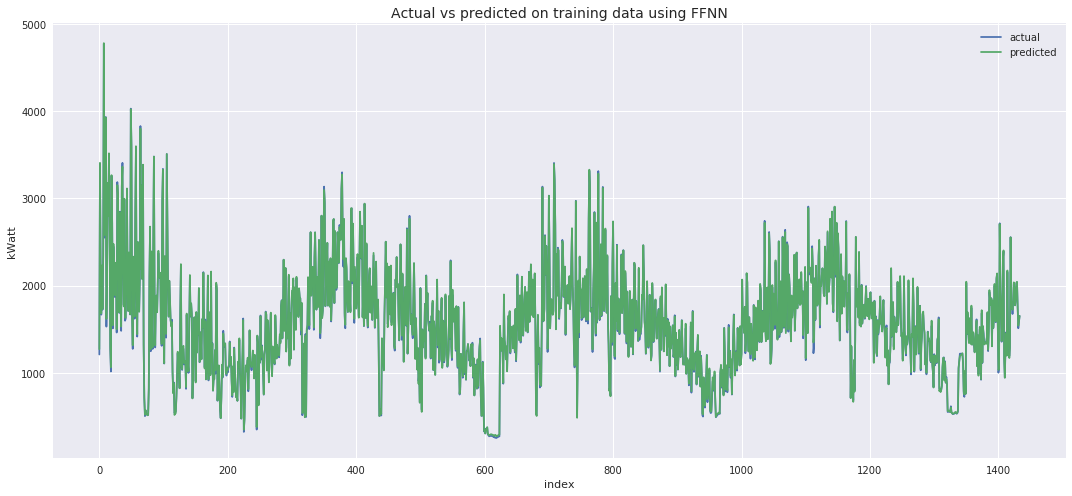

In [12]:
plt.plot(y_train_inv, label='actual')
plt.plot(y_train_pred_inv, label='predicted')
plt.ylabel('kWatt')
plt.xlabel('index')
plt.title('Actual vs predicted on training data using FFNN', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

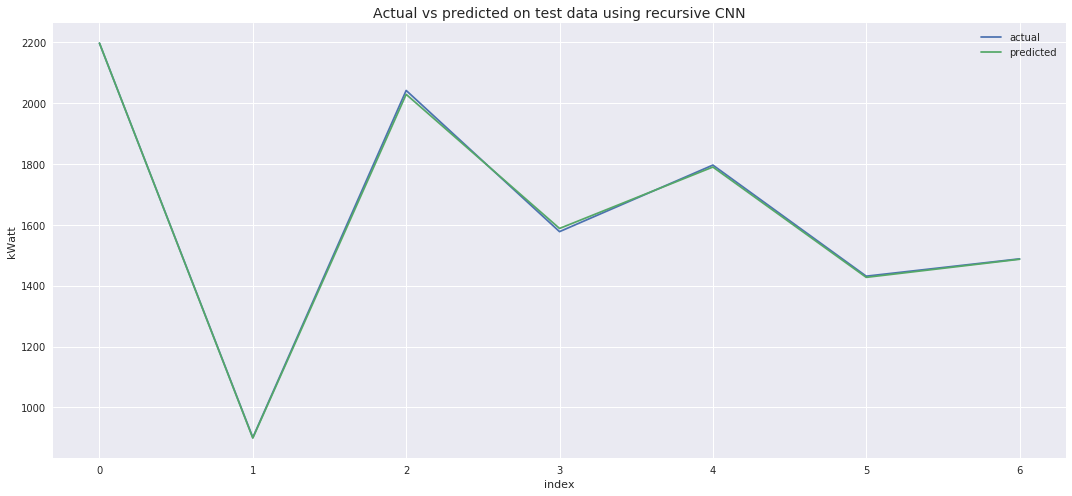

In [14]:
plt.plot(y_test_inv, label='actual')
plt.plot(y_test_pred_inv, label='predicted')
plt.ylabel('kWatt')
plt.xlabel('index')
plt.title('Actual vs predicted on test data using recursive CNN', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

#### 